In [1]:
import pandas as pd
import sys
import openpyxl
import seaborn as sns


In [2]:
sc = pd.read_csv('DataAnalyst_Ecom_data_sessionCounts.csv')
adds=pd.read_csv('DataAnalyst_Ecom_data_addsToCart.csv')

In [3]:
def clean_tables(session_cts, cart_adds):
    """
    Clean session count and cart adds dataframes by extracting month and year information,
    mapping month numbers to month names, and ensuring consistent ordering of month names.
    
    Args:
        session_cts (DataFrame): DataFrame containing session count data.
        cart_adds (DataFrame): DataFrame containing cart adds data.
        
    Returns:
        tuple: A tuple containing the cleaned session count and cart adds DataFrames.
    """
    
    # Define a function to map month numbers to month names
    def map_month(month_number):
        return pd.to_datetime(month_number, format='%m').strftime('%B')

    # Extract month and year information from session_cts dataframe
    session_cts['Month'] = session_cts['dim_date'].str.split('/').str[0]
    session_cts['Year'] = session_cts['dim_date'].str.split('/').str[2]
    session_cts['Year'] = '20' + session_cts['Year'].apply(lambda x: x.zfill(2))  # Ensure year has 4 digits
    session_cts['Year'] = session_cts['Year'].astype(int)  # Convert year to integer
    session_cts['month_name'] = session_cts['Month'].apply(map_month)  # Map month numbers to month names
    session_cts['dim_deviceCategory'] = session_cts['dim_deviceCategory'].str.title()  # Capitalize device categories
    
    # Extract month information from cart_adds dataframe
    cart_adds['dim_month'] = cart_adds['dim_month'].astype(str)
    cart_adds['month_name'] = cart_adds['dim_month'].apply(map_month)
    
    # Ensure consistent ordering of month names
    month_order = list(session_cts['month_name'].unique())

    # Apply categorical ordering to month_name column
    session_cts['month_name'] = pd.Categorical(session_cts['month_name'], categories=month_order, ordered=True)
    cart_adds['month_name'] = pd.Categorical(cart_adds['month_name'], categories=month_order, ordered=True)
    
    # Rename dim_year column to Year in cart_adds dataframe
    cart_adds.rename(mapper={'dim_year': 'Year'}, axis=1, inplace=True)

    return session_cts, cart_adds

In [4]:
def filter_last_months(df):
    """
    Filter the DataFrame to retain only the rows corresponding to the last two months.
    
    Args:
        df (DataFrame): DataFrame containing data with columns 'Year' and 'month_name'.
        
    Returns:
        DataFrame: Filtered DataFrame containing only the rows corresponding to the last two months.
    """
    # Sort the DataFrame by 'Year' and 'month_name' to ensure chronological order
    df = df.sort_values(by=['Year', 'month_name'])
    
    # Extract the last two unique month names
    last_months = df['month_name'].unique()[-3:]
    
    # Filter the DataFrame to retain only the rows corresponding to the last two months
    filtered_df = df[df['month_name'].isin(last_months)]
    
    return filtered_df

In [5]:
def create_month_device(md):
    """
    Create a new DataFrame by aggregating data based on month and device category,
    and calculating the ECR (ecommerce conversion rate) for each group.
    
    Note: Used provided dataset which was July 2012 - June 2013 Data. 
    I ordered months in order based on year and month. 
    In future would add functionality 
    to pull last 12 months of data and order in months 
    based the data no matter which month was current.

    Args:
        md (DataFrame): DataFrame containing data with columns 'month_name', 'dim_deviceCategory',
                        'sessions', 'transactions', and 'QTY'.

    Returns:
        DataFrame: A new DataFrame containing aggregated data for each month and device category,
                   along with the calculated ECR.
    """
    # Define aggregation functions for each column
    aggregation_functions = {
        'sessions': 'sum',
        'transactions': 'sum',
        'QTY': 'sum'
    }
    
    # Define the desired order of months
    month_order = ['July', 'August', 'September', 'October', 'November',
                   'December', 'January', 'February', 'March',
                   'April', 'May', 'June']
    
    # Convert 'month_name' column to categorical with specified order
    md['month_name'] = pd.Categorical(md['month_name'], categories=month_order, ordered=True)

    # Group data by 'month_name' and 'dim_deviceCategory', then aggregate using defined functions
    grouped_md = md.groupby(['month_name', 'dim_deviceCategory']).agg(aggregation_functions)
    
    # Calculate ECR (E-commerce Conversion Rate) by dividing 'transactions' by 'sessions'
    grouped_md['ECR'] = grouped_md['transactions'] / grouped_md['sessions']

    return grouped_md

In [6]:
def create_browser_device(md):
    """
    Create a new DataFrame by aggregating data based on month and device category,
    and calculating the ECR (e-commerce conversion rate) for each group.
    
    Note: Used provided dataset which was July 2012 - June 2013 Data. 
    I ordered months in order based on year and month. 
    In future would add functionality 
    to pull last 12 months of data and order in months 
    based the data no matter which month was current.

    Args:
        md (DataFrame): DataFrame containing data with columns 'dim_deviceCategory',
                        'sessions', 'transactions', and 'QTY'.

    Returns:
        DataFrame: A new DataFrame containing aggregated data for each month and device category,
                   along with the calculated ECR.
    """
    # Define aggregation functions for each column
    aggregation_functions = {
        'sessions': 'sum',
        'transactions': 'sum',
        'QTY': 'sum'
    }


    # Group data by 'month_name' and 'dim_deviceCategory', then aggregate using defined functions
    grouped_md = md.groupby(['dim_browser']).agg(aggregation_functions)
    
    # Calculate ECR (E-commerce Conversion Rate) by dividing 'transactions' by 'sessions'
    grouped_md['ECR'] = grouped_md['transactions'] / grouped_md['sessions']

    return grouped_md

In [7]:
def create_mtm_compare(session_counts, adds):
    """
    Create a DataFrame for month-to-month comparison of session counts and cart adds data.
    
    Next steps with this function would be to impliment a number of months feature, 
    or select months and years to compare. This could be valuable for reoccuring reporting. 

    Args:
        session_counts (DataFrame): DataFrame containing session count data with columns 'month_name',
                                     'sessions', 'transactions', and 'QTY'.
        adds (DataFrame): DataFrame containing cart adds data with columns 'month_name' and 'addsToCart'.

    Returns:
        DataFrame: A DataFrame containing month-to-month comparison metrics for session counts and cart adds.
    """
    # Filter session_counts to retain only the last three months
    last_three = filter_last_months(session_counts)
    
    # Define aggregation functions for session_counts
    aggregation_functions = {
        'sessions': 'sum',
        'transactions': 'sum',
        'QTY': 'sum'
    }
    
    # Group last_three by 'month_name' and aggregate session counts data
    last_three_grouped = last_three.groupby(['month_name']).agg(aggregation_functions)
    
    # Calculate ECR (E-commerce Conversion Rate) for last_three_grouped
    last_three_grouped['ECR'] = last_three_grouped['transactions'] / last_three_grouped['sessions']
    
    # Fill NaN values with 0 and remove rows with all 0 values
    last_three_grouped.fillna(0, inplace=True)
    last_three_grouped = last_three_grouped.loc[(last_three_grouped != 0).all(axis=1)]
    
    # Merge adds data with last_three_grouped on 'month_name'
    last_three_grouped = last_three_grouped.merge(adds[['month_name', 'addsToCart']], on=['month_name'], how='inner')
    
    # Calculate absolute and percent changes for each metric
    for col in ['sessions', 'transactions', 'QTY', 'ECR', 'addsToCart']:
        # Absolute change
        last_three_grouped[f'{col}_abs_change'] = last_three_grouped[col].diff()

        # Percent change
        last_three_grouped[f'{col}_pct_change'] = last_three_grouped[col].pct_change() * 100

    # Rearrange columns and set 'month_name' as index
    last_three_grouped = last_three_grouped[
        ['month_name','sessions', 'sessions_abs_change', 'sessions_pct_change',
         'addsToCart', 'addsToCart_abs_change', 'addsToCart_pct_change',
         'transactions', 'transactions_abs_change', 'transactions_pct_change',
         'QTY', 'QTY_abs_change', 'QTY_pct_change',
         'ECR', 'ECR_abs_change', 'ECR_pct_change']].set_index('month_name')
    
    # Transpose DataFrame for better readability
    last_three_grouped = last_three_grouped.transpose()
    
    return last_three_grouped

In [8]:
def create_month_device_totals(month_device):
    """
    Create a DataFrame with total values for each device category across all months.

    Args:
        month_device (DataFrame): DataFrame containing monthly data for different device categories.
                                Cols needed: month_name, dim_deviceCategory

    Returns:
        DataFrame: DataFrame with total values for each device category across all months, including a 'Total' row for each month.
    """
    # Reset index to ensure 'month_name' becomes a regular column
    month_device = month_device.reset_index()
    
    # Calculate totals for each month across all device categories
    totals = month_device.groupby('month_name').sum().reset_index()
    
    # Add a 'Total' category to identify total values
    totals['dim_deviceCategory'] = 'Total'
    
    # Concatenate original data with total rows
    month_device_with_totals = pd.concat([month_device, totals], ignore_index=False)
    
    # Define the order of device categories (including 'Total') for sorting
    order = ['Desktop', 'Mobile', 'Tablet', 'Total']

    # Convert 'dim_deviceCategory' to categorical and enforce the specified order
    month_device_with_totals['dim_deviceCategory'] = pd.Categorical(month_device_with_totals['dim_deviceCategory'], 
                                                          categories=order, ordered=True)
    
    # Sort the DataFrame by 'month_name' and 'dim_deviceCategory'
    month_device_with_totals =month_device_with_totals.sort_values(by=['month_name','dim_deviceCategory']).reset_index()
    
    # Remove the index column
    month_device_with_totals.drop('index', inplace=True, axis=1)
    
    return month_device_with_totals




In [9]:
sc, adds = clean_tables(sc, adds)
month_device_agg = create_month_device(sc)



In [10]:
brow = create_browser_device(sc)

In [11]:
browser = brow.sort_values('sessions', ascending=False)[:10]

In [12]:
mtm_compare = create_mtm_compare(sc, adds)

In [13]:
month_device_with_totals = create_month_device_totals(month_device_agg)

In [14]:
with pd.ExcelWriter('website_agg.xlsx') as writer:
    # Write each DataFrame to a separate sheet
    month_device_agg.to_excel(writer, sheet_name='Month Device Agg', index=True)
    mtm_compare.to_excel(writer, sheet_name='Month to Month Comparision', index=True)
    browser.to_excel(writer, sheet_name='Browser', index=True)
    month_device_with_totals.to_excel(writer, sheet_name='Month_device_agg_tot', index=True)

In [15]:
top = browser.head(7).reset_index()

In [16]:
top.head()

,dim_browser,sessions,transactions,QTY,ECR
0,Safari,5952256,140847,263776,0.023663
1,Chrome,2527254,66247,125468,0.026213
2,Safari (in-app),518573,3046,5113,0.005874
3,Firefox,495779,17376,31279,0.035048
4,Internet Explorer,469325,14373,11016,0.030625


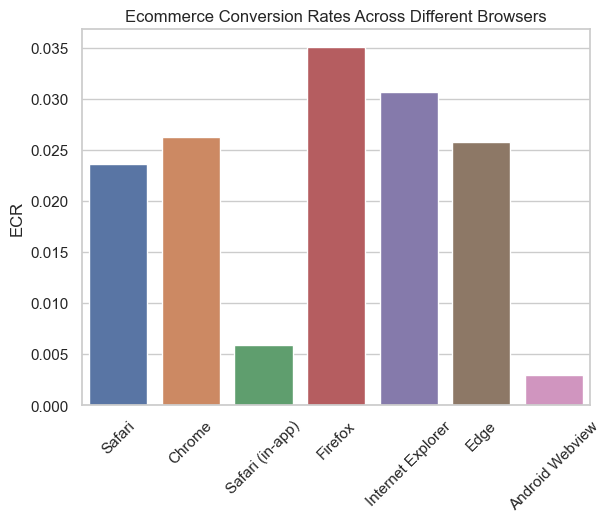

In [17]:
import matplotlib.pyplot as plt

sns.set(style="whitegrid")  # Set the style of the plot

sns.barplot(data=top, x='dim_browser', y='ECR')
plt.title('Ecommerce Conversion Rates Across Different Browsers')
plt.tight_layout()
plt.xticks(rotation=45)
plt.xlabel('')
plt.show()


/var/folders/rg/3mv_js5n6lq2h93ynk_9vz_m0000gp/T/ipykernel_24199/515419810.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
/var/folders/rg/3mv_js5n6lq2h93ynk_9vz_m0000gp/T/ipykernel_24199/515419810.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
/var/folders/rg/3mv_js5n6lq2h93ynk_9vz_m0000gp/T/ipykernel_24199/515419810.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
/var/folders/rg/3mv_js5n6lq2h93ynk_9vz_m0000gp/T/ipykernel_24199/515419810.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


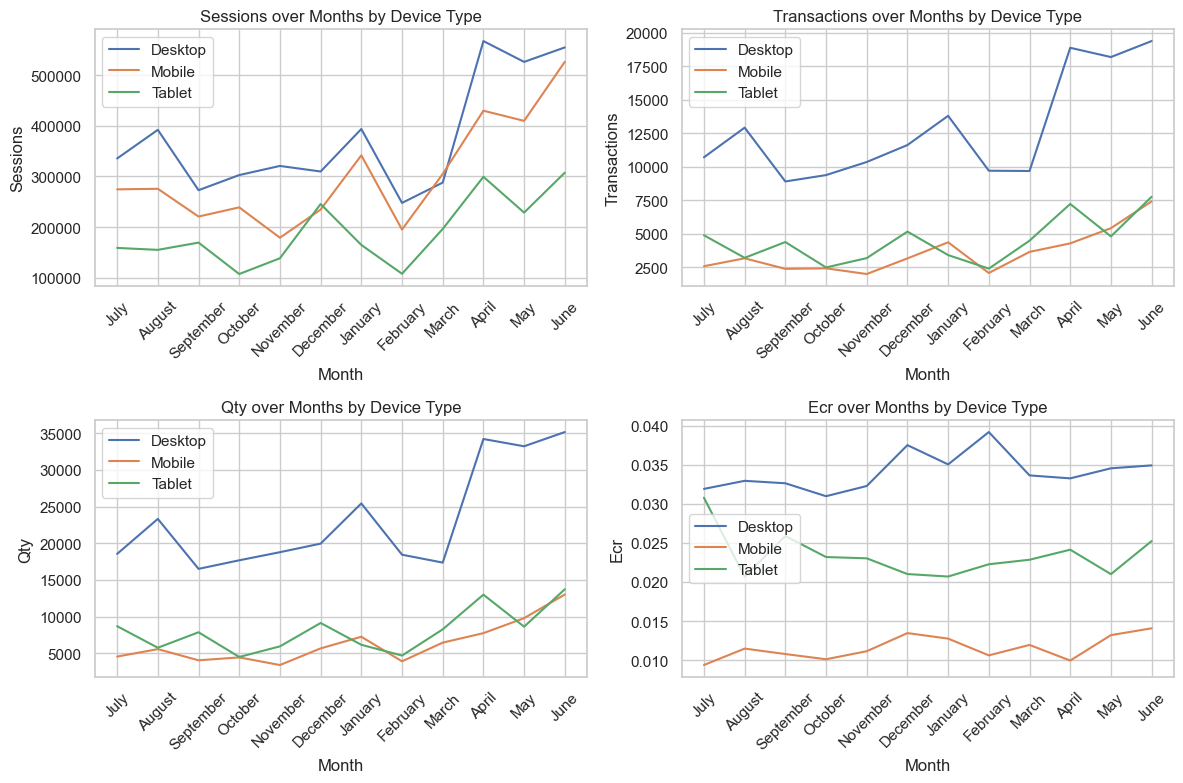

In [18]:
sns.set(style="whitegrid")  # Set the style of the plot

# Define the variables to use for hue
hue_variables = ['sessions','transactions', 'QTY', 'ECR']

# Create a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Plot each variable in the series
for i, hue_var in enumerate(hue_variables):
    ax = axes[i]  # Get the current axis
    sns.lineplot(data=month_device_agg, x='month_name', y=hue_var, hue='dim_deviceCategory', ax=ax)
    ax.set_title(f'{str.title(hue_var)} over Months by Device Type')
    ax.set_ylabel(str.title(hue_var))  # Customize y-axis label if needed
    ax.set_xlabel('Month')  # Customize x-axis label if needed
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    ax.legend()  # Add legend with the hue variable as title

# Adjust layout to avoid overlapping labels
plt.tight_layout()
# plt.xticks(rotation=45)
# Show the plots
plt.show()